In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

In [16]:
number_of_tests = 50
rho_spread_factor = 1.5
rho_max = 150
layers_min = 1
layers_max = 5
min_depth = 1
max_depth = 25

world_boundary_v = [-10 * max_depth, 0]  # [right, left border] relatively to the middle
world_boundary_h = [10 * max_depth, -4 * max_depth]  # [top, bottom border]


In [17]:
layers_pos = [-8, -18]
resistivity_map = [[1, 20], [2, 50], [3, 150]]

In [18]:


test_results = {}

# INPUT MODEL - SUBSURFACE START #
world = mt.createWorld(start=world_boundary_v, end=world_boundary_h,
                       layers=layers_pos)  # ,
# marker=np.linspace(1, tests_horizontal['layer_n']['hor_1'],
#                  tests_horizontal['layer_n']['hor_1']))

geometry = world  # +block

measurement_scheme = ert.createERTData(elecs=np.linspace(start=-45, stop=45, num=91), schemeName='slm')
for electrode in measurement_scheme.sensors():
    geometry.createNode(electrode)
    geometry.createNode(electrode - [0, 0.1])  # What does it do?

mesh = mt.createMesh(geometry, quality=34)  # , area=2)#

 # [0]

input_model = pg.solver.parseMapToCellArray(resistivity_map, mesh)  # rename to input_mesh

# INPUT MODEL - SUBSURFACE MODEL END ###

# SIMULATE ERT MEASUREMENT - START ###
data = ert.simulate(mesh, scheme=measurement_scheme, res=resistivity_map, noiseLevel=1, noiseAbs=1e-6, seed=1337)
data.remove(data['rhoa'] < 0)
# SIMULATE ERT MEASUREMENT - END ###

ert_manager = ert.ERTManager(sr=False, useBert=True, verbose=True, debug=False)

# RUN INVERSION #
k0 = pg.physics.ert.createGeometricFactors(data)
model_inverted = ert_manager.invert(data=data, lam=20, paraDX=0.25, paraMaxCellSize=5, paraDepth=max_depth, quality=34,
                                    zPower=0.4)
result = ert_manager.inv.model
result_array = result.array()

input_model2 = pg.interpolate(srcMesh=mesh, inVec=input_model, destPos=ert_manager.paraDomain.cellCenters())

input_model2_array = input_model2.array()

experiment_results = pd.DataFrame(data={'X': ert_manager.paraDomain.cellCenters().array()[:, 0],
                                        'Y': ert_manager.paraDomain.cellCenters().array()[:, 1],
                                        'Z': ert_manager.paraDomain.cellCenters().array()[:, 2],
                                        'INM': input_model2_array,
                                        'RES': result_array})#,
                                        #'CLASS': input_class})


#experiment_results.to_csv('results/results/'+test_name+'.csv')

27/01/21 - 11:59:23 - pyGIMLi - INFO - Save RVector binary
27/01/21 - 11:59:23 - pyGIMLi - INFO - Cache stored: /home/felikskrno/.cache/pygimli/14932874940015120856
27/01/21 - 11:59:23 - pyGIMLi - INFO - Found 2 regions.
27/01/21 - 11:59:23 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
27/01/21 - 11:59:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/01/21 - 11:59:23 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
27/01/21 - 11:59:23 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
27/01/21 - 11:59:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/01/21 - 11:59:23 - pyGIMLi - INFO - Starting inversion.
27/01/21 - 11:59:23 - pyGIMLi - INFO - Set default startmodel to median(data values)=26.654338176157033
27/01/21 - 11:59:23 - pyGIMLi - INFO - Created startmodel from forward operator: 2373 [26.654338176157033,...,26.654338176157033]


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000943083472701 : 0.0459008826982054
<class 'pygimli.physics.ert.ert.ERTManager'>.applyMesh(methodManager.py:647) : Mesh: Nodes: 1745 Cells: 3160 Boundaries: 4904
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f04c2dd98f0>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f04c2799730>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f04c2799430>
min/max (data): 19.01/66.38
min/max (error): 1.0%/4.59%
min/max (start model): 26.65/26.65
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 152.73 (dPhi = 23.71%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 153.21 (dPhi = -0.32%) lam: 20.0
----------------------

# Added by Florian

Jacobian was already calculated during each iteration of the inversion above. If we access it after the inversion, it contains the sensitivities of the final model (just as a side note: sensitivity depends on current flow, current flow depends on resisitivity, hence sensitivity is model-dependent, this is what makes the inverse problem non-linear, exactly the topic of the last lecture).

/home/felikskrno/anaconda3/envs/MasterEnv/lib/python3.7/site-packages/pygimli/viewer/mpl/colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f04c2efeb50>)

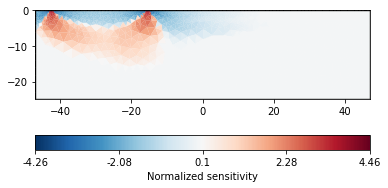

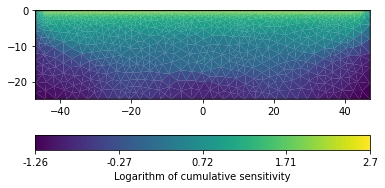

In [19]:
jac = ert_manager.fop.jacobian() # 
# Normalization only for visualization!
sens = jac[200] # one row of J = one measurement sensitivity
normsens = pg.utils.logDropTol(sens/ert_manager.paraDomain.cellSizes(), 1e-4)
pg.show(ert_manager.paraDomain, normsens, cMap="RdBu_r", label="Normalized sensitivity")

# Coverage = cumulative sensitivity = all measurements
cov = ert_manager.coverage()
pg.show(ert_manager.paraDomain, cov, label="Logarithm of cumulative sensitivity")

In [20]:
print(len(cov))
print(len(input_model2))

2373
2373


In [21]:
cov_out = pg.interpolate(srcMesh=ert_manager.paraDomain, inVec=cov, destPos=ert_manager.paraDomain.cellCenters())

In [22]:
print(len(cov_out))

2373


In [23]:
print(cov)
print(cov_out)
print(cov-cov_out)

[ 1.28713339  2.6087242   2.34607952 ... -0.75506235 -0.67270966
 -0.70294602]
2373 [1.3291159401562394,...,-0.6942665210742556]
[-0.04198255  0.29842257  0.04712001 ... -0.04502591 -0.00895796
 -0.0086795 ]


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f04bb6f9b10>)

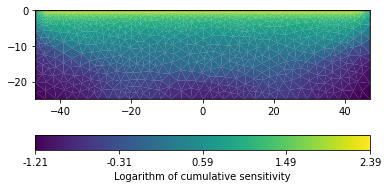

In [24]:
pg.show(ert_manager.paraDomain, cov_out, label="Logarithm of cumulative sensitivity")